# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench
import subprocess

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

os.environ['GASTROSNAPPER_CONFPATH'] = os.getcwd() + '/snapper_config'
os.environ['GASTROSNAPPER_REFPATH'] = os.getcwd() + '/reference_genomes'

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Set PICARD_JAR environment variable
picard_path = subprocess.run(['conda', 'run', '--name', 'snapperdb', 'which', 'picard'],
                             capture_output=True).stdout.strip().decode('utf-8')
picard_bin_dir = os.path.dirname(picard_path)
picard_link = os.readlink(picard_path)
picard_true_path = os.path.abspath(picard_bin_dir + '/' + picard_link)
picard_jar = os.path.dirname(picard_true_path) + '/picard.jar'

# snapperdb needs 'PICARD_JAR' environment variable set
print(picard_jar)
os.environ['PICARD_JAR'] = picard_jar

# Set GATK_JAR environment variable
gatk_path = subprocess.run(['conda', 'run', '--name', 'snapperdb', 'which', 'gatk3'],
                          capture_output=True).stdout.strip().decode('utf-8')
gatk_bin_dir = os.path.dirname(gatk_path)
gatk_link = os.readlink(gatk_path)
gatk_true_path = os.path.abspath(gatk_bin_dir + '/' + gatk_link)
gatk_jar = os.path.dirname(gatk_true_path) + '/GenomeAnalysisTK.jar'

# snapperdb needs 'GATK_JAR' environment variable set
print(gatk_jar)
os.environ['GATK_JAR'] = gatk_jar

/home/CSCScience.ca/apetkau/miniconda3/envs/snapperdb/share/picard-2.23.6-0/picard.jar
/home/CSCScience.ca/apetkau/miniconda3/envs/snapperdb/opt/gatk-3.8/GenomeAnalysisTK.jar


# Software versions

In [2]:
!conda run --name snapperdb samtools --version
!conda run --name snapperdb bcftools --version

samtools 1.11
Using htslib 1.11
Copyright (C) 2020 Genome Research Ltd.

bcftools 1.11
Using htslib 1.11
Copyright (C) 2020 Genome Research Ltd.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.



In [3]:
!conda run --name snapperdb bwa 2>&1 | grep Version

Version: 0.7.17-r1188


In [4]:
!conda run --name snapperdb bowtie2 --version

/home/CSCScience.ca/apetkau/miniconda3/envs/snapperdb/bin/bowtie2-align-s version 2.3.5.1
64-bit
Built on 
Wed Apr 17 02:40:25 UTC 2019
Compiler: gcc version 7.3.0 (crosstool-NG 1.23.0.450-d54ae) 
Options: -O3 -m64 -msse2 -funroll-loops -g3 -fvisibility-inlines-hidden -std=c++17 -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/CSCScience.ca/apetkau/miniconda3/envs/snapperdb/include -fdebug-prefix-map=/opt/conda/conda-bld/bowtie2_1581374363721/work=/usr/local/src/conda/bowtie2-2.3.5.1 -fdebug-prefix-map=/home/CSCScience.ca/apetkau/miniconda3/envs/snapperdb=/usr/local/src/conda-prefix -std=c++98 -DPOPCNT_CAPABILITY -DWITH_TBB -DNO_SPINLOCK -DWITH_QUEUELOCK=1                                                                                                                                                                                                                                           

In [5]:
!conda run --name snapperdb gatk3 --version

3.8-1-0-gf15c1c3ef



In [6]:
!conda run --name snapperdb picard CheckIlluminaDirectory --version 2>&1 | grep Version

Version:2.23.6


# Benchmark

## Input data and constants

In [7]:
input_dir = '../data/input-files/reads'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

sample_sizes = [1,10,20,30,40,50,60,70,80]
#sample_sizes = [3]

nprocs = 4
output_dir = 'output'
snapper_config = 'snapper_config'
reference_dir = 'reference_genomes'
config_file = f'{snapper_config}/config.txt'

reference_genome_name = '2011C-3609'

db_name = 'ecoli_snapperdb'
db_user = 'snapperdb'
db_pass = 'snapperdb'
db_host = 'localhost'

benchmark.create_folder_if_doesnt_exist(output_dir)
benchmark.create_folder_if_doesnt_exist(snapper_config)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS994', 'MOD1_LS995', 'MOD1_LS996', 'MOD1_LS997', 'MOD1_LS998', 'PNUSA000194', 'PNUSA000195', 'PNUSA000196', 'PNUSAL000730', 'PNUSAL000870', 'PNUSAL000957', 'PNUSAL001024', 'SIM_CFSAN000189', 'SIM_CFSAN000191', 'SIM_CFSAN000211', 'SIM_CFSAN000212', 'SIM_CFSAN000228', 'SIM_CFSAN000661', 'SIM_CFSAN000669', 'SIM_CFSAN000700', 'SIM_CFSAN000752', 'SIM_

## Setup database

### Postgres database

Create user with proper permissions

```
sudo su -l postgres
psql
create user snapperdb password 'snapperdb';
alter user snapperdb with superuser;
create database ecoli_snapperdb;
create database snapperdb; # Need snapperdb database to connect later
grant all on database ecoli_snapperdb to snapperdb;
```

Note, when logging into the database to test out, make sure to specify the hostname so it uses password authentication.

```
psql ecoli_snapperdb snapperdb --host localhost
```

### Create config file

In [8]:
import textwrap

with open(config_file, 'w') as f:
    f.write(textwrap.dedent(f"""
    snpdb_name {db_name}
    reference_genome {reference_genome_name}
    pg_uname {db_user}
    pg_pword {db_pass}
    pg_host {db_host}
    depth_cutoff 10
    mq_cutoff 30
    ad_cutoff 0.9
    average_depth_cutoff 30
    mapper bwa
    mapper_threads 8
    variant_caller gatk
    variant_caller_threads 8
    """).strip() + '\n')

## Benchmark functions

In [9]:
import psycopg2, glob, os
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

def reset_func():
    # Remove processed files for the reference genome
    for file in glob.glob(f"reference_genomes/{reference_genome_name}.*"):
        if(file.split(".")[-1] != "fa"):
            os.remove(file)
    
    # https://github.com/phe-bioinformatics/snapperdb#deleting-or-purging-your-database
    
    # Connect to the database, drop the whole database made by snapperdb and close the connection
    
    psql_conn = psycopg2.connect(f"user={db_user} host={db_host} password={db_pass}")
    psql_conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    
    psql_cursor = psql_conn.cursor()
    
    psql_cursor.execute(f"DROP DATABASE IF EXISTS {db_name};")
    
    psql_cursor.close()
    psql_conn.close()
    
def sampling_func(input_size):
    return input_samples[:input_size]

# Index

make_snpdb_command = {
    "use_parallel": False,
    "command": "conda run --name snapperdb run_snapperdb.py make_snpdb -c config.txt"
}

fastq_to_db_command = {
    "command": f'conda run --name snapperdb run_snapperdb.py fastq_to_db -c config.txt "{input_dir}/%_1.fastq.gz" "{input_dir}/%_2.fastq.gz"',
    "parallel_args": f"-j {nprocs} -I%"
}

update_distance_matrix_command = {
    "use_parallel": False,
    "command": "conda run --name snapperdb run_snapperdb.py update_distance_matrix -c config.txt"
}

update_clusters_command = {
    "use_parallel": False,
    "command": "conda run --name snapperdb run_snapperdb.py update_clusters -c config.txt"
}

# Query

get_strains_command = {
    "use_parallel": False,
    "command": "conda run --name snapperdb run_snapperdb.py get_strains -c config.txt"
}

# Benchmark

In [10]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [make_snpdb_command, fastq_to_db_command, update_distance_matrix_command, update_clusters_command],
        "query": [get_strains_command]
    }, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
conda run --name snapperdb run_snapperdb.py make_snpdb -c config.txt

STDOUT: Warning: FastBinaryTree not available, using Python version BinaryTree.
Namespace(command='make_snpdb', config_file='config.txt', fastqs=[], log_dir='/home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/snapperdb')
### Cant connect to SnapperDB ecoli_snapperdb
The SNPdb ecoli_snapperdb does not exist - running sql to create database
/home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/snapperdb/reference_genomes/2011C-3609.R1.fastq /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/snapperdb/reference_genomes/2011C-3609.R2.fastq /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/snapperdb/reference_genomes/2011C-3609.fa
Calulated depth is 110.85 - cuttoff is 30
### Completed 2020-12-03 18:04:53.192678


-------------
STDERR: [wgsim] seed = 1607039613
[wgsim_core] calculating the total length of the reference sequence...
[wgsim_core] 7 sequences, total length: 5412686
[bwa

# Save and reload results

In [11]:
save_path = "snapperdb-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(samples_per_sample_size)

[['2014C-3598'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-3850,', '2014C-3857,', '2014C-3907,', '2014D-0067,', '2014D-0068,', '2014D-0070,', '2014D-0189,', 'CFSAN002349,', 'CFSAN023463,', 'CFSAN023464,', 'CFSAN023465,', 'CFSAN023466,', 'CFSAN023467,', 'CFSAN023468,', 'CFSAN023469,', 'CFSAN023470,', 'CFSAN023471,', 'D5663,', 'D7316,', 'D7319,', 'D7320,', 'D7321,', 'D7322,', 'D7323'], ['2014C-3598,', '2014C-3599,', '2014C-3600,', '2014C-3655,', '2014C-3656,', '2014C-3840,', '2014C-

# Plot

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 1164.62, 'memory': 1339035648.0, 'disk_read': 6601686454.0, 'disk_write': 5540061179.0}, {'runtime': 2177.22, 'memory': 4795629568.0, 'disk_read': 34338561488.0, 'disk_write': 22354668482.0}, {'runtime': 2817.71, 'memory': 53544222720.0, 'disk_read': 52397412386.0, 'disk_write': 34894436034.0}, {'runtime': 4384.79, 'memory': 54131322880.0, 'disk_read': 91889569573.0, 'disk_write': 65408412082.0}, {'runtime': 5644.14, 'memory': 53567791104.0, 'disk_read': 142511484110.0, 'disk_write': 105286110429.0}, {'runtime': 7090.57, 'memory': 54365429760.0, 'disk_read': 176177275541.0, 'disk_write': 130496602972.0}, {'runtime': 8280.08, 'memory': 53390233600.0, 'disk_read': 211291696981.0, 'disk_write': 156832651466.0}, {'runtime': 9732.86, 'memory': 51442958336.0, 'disk_read': 239526184568.0, 'disk_write': 175750304744.0}, {'runtime': 11037.21, 'memory': 54649942016.0, 'disk_read': 268281700352.0, 'disk_write': 194647711358.0}]


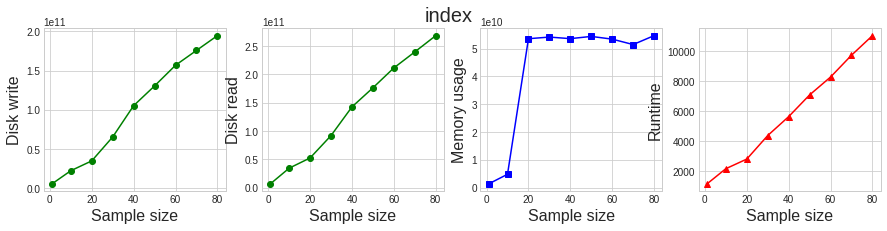

In [13]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 2.98, 'memory': 87506944.0, 'disk_read': 65573585.0, 'disk_write': 62283.0}, {'runtime': 2.94, 'memory': 95186944.0, 'disk_read': 65573983.0, 'disk_write': 62715.0}, {'runtime': 2.9, 'memory': 85630976.0, 'disk_read': 65573778.0, 'disk_write': 62715.0}, {'runtime': 2.9, 'memory': 84733952.0, 'disk_read': 65574018.0, 'disk_write': 62715.0}, {'runtime': 2.94, 'memory': 95178752.0, 'disk_read': 65573728.0, 'disk_write': 62715.0}, {'runtime': 2.91, 'memory': 87085056.0, 'disk_read': 65573908.0, 'disk_write': 62715.0}, {'runtime': 2.94, 'memory': 94695424.0, 'disk_read': 65573918.0, 'disk_write': 62715.0}, {'runtime': 2.9, 'memory': 93659136.0, 'disk_read': 65573620.0, 'disk_write': 62715.0}, {'runtime': 2.93, 'memory': 94146560.0, 'disk_read': 65573864.0, 'disk_write': 62715.0}]


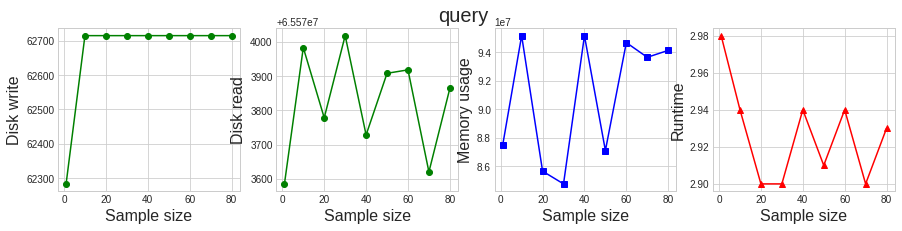

In [14]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")